## Fine Tuning DistilBERT, MobileBERT and TinyBERT for Fake News Detection

In [ ]:
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade
!pip install -U openpyxl
import warnings
warnings.filterwarnings('ignore')

### Import the Data

In [7]:
import pandas as pd
df = pd.read_excel("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/fake_news.xlsx")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20757 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [4]:
df.isnull().sum()

,0
id,0
title,558
author,1957
text,43
label,0


In [8]:
df = df.dropna()

In [9]:
df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [10]:
df.shape

(18281, 5)

In [11]:
df['label'].value_counts()

,count
label,
0,10361
1,7920


### Exploratory Data Analysis

In [12]:
import matplotlib.pyplot as plt


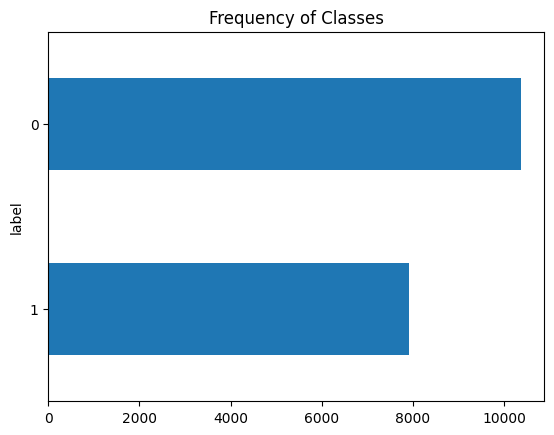

In [14]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [24]:
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['title_tokens'].head()


,title_tokens
0,21.0
1,13.5
2,10.5
3,15.0
4,21.0


In [25]:
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'].head()

,text_tokens
0,1230.0
1,1065.0
2,1899.0
3,835.5
4,231.0


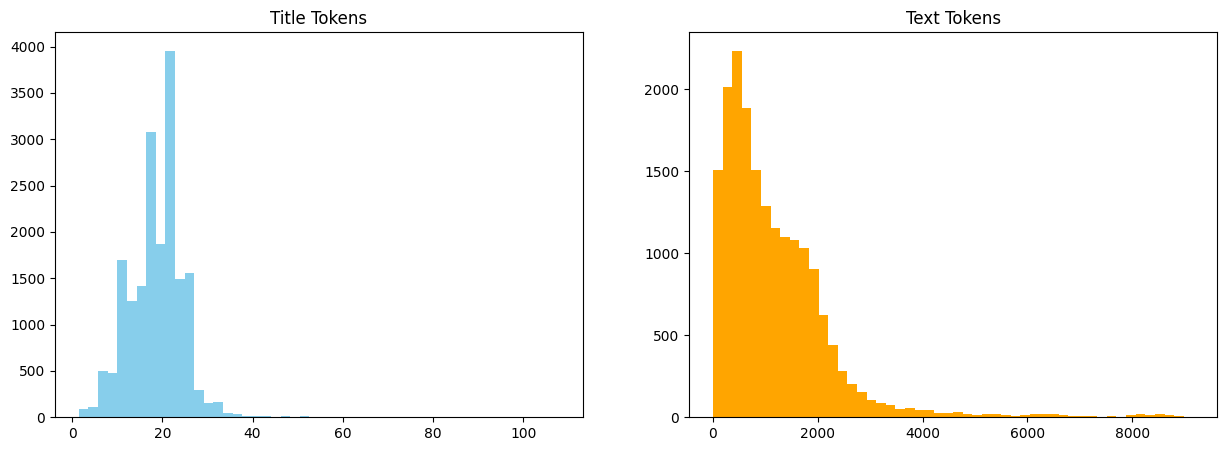

In [26]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

### Train Test Split

In [27]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test_df, test_size=1/3, stratify=test_df['label'])

train_df.shape, test_df.shape, validation.shape

((12796, 7), (5485, 7), (1829, 7))

In [28]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train_df, preserve_index=False),
        'test': Dataset.from_pandas(test_df, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 5485
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

### Tokenize the Data

In [29]:
dataset['train'][0]

{'id': 5953,
 'title': 'Franken: I’m ’Troubled’ By Sessions ’Exaggerating, Misrepresenting’ His Civil Rights History - Breitbart',
 'author': 'Pam Key',
 'text': 'Tuesday on MSNBC’s “For the Record with Greta,” while discussing today’s confirmation hearing of   Donald Trump’s pick for Attorney General, Sen. Jeff Sessions ( ) Sen. Al Franken ( ) said he was “very troubled” over what he described as Sessions “exaggerating, misrepresenting” his handling of civil rights cases.  Franken said, “We have another day of hearings and I’m going to reserve until I’m able to absorb everything. I was very troubled by the answers to my lines of questioning, particularly on his exaggerating, misrepresenting his history in terms of civil rights cases. He claimed in his questionnaire that he had had a personal  —   he had personally supervised or personal activity on a number of civil rights cases that he later had to produce an addenda to that and  —   addendum  —   and he did exaggerate his history. P

### Tokenize the Data

In [30]:
from transformers import AutoTokenizer

text = 'A clever fox jump over the lazy dog'

model_name = 'distilbert-base-uncased'
distibert_tokenizer = AutoTokenizer.from_pretrained(model_name)
distibert_tokens = distibert_tokenizer.tokenize(text)
distibert_tokens

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

['a', 'clever', 'fox', 'jump', 'over', 'the', 'lazy', 'dog']

In [31]:
model_name = 'google/mobilebert-uncased'
mobilebert_tokenizer = AutoTokenizer.from_pretrained(model_name)
mobilebert_tokens = mobilebert_tokenizer.tokenize(text)
mobilebert_tokens

config.json:   0%|          | 0.00/847 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

['a', 'clever', 'fox', 'jump', 'over', 'the', 'lazy', 'dog']

In [33]:
model_name = "huawei-noah/TinyBERT_General_4L_312D"
tinybert_tokenizer = AutoTokenizer.from_pretrained(model_name)
tinybert_tokens = tinybert_tokenizer.tokenize(text)
tinybert_tokens

['a', 'clever', 'fox', 'jump', 'over', 'the', 'lazy', 'dog']

In [35]:
distibert_tokenizer, mobilebert_tokenizer, tinybert_tokenizer

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 MobileBertTokenizerFast(name_or_path='google/mobilebert-uncased', vocab_size=30522, model_max_length=100

In [36]:
def tokenize(batch):
  temp = distibert_tokenizer(batch['title'], padding=True, truncation=True)
  return temp

In [37]:
encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/5485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

### Model Building

In [38]:
from transformers import AutoModelForSequenceClassification, AutoConfig
import torch

label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

model_name = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

num_labels = len(label2id)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


config = AutoConfig.from_pretrained(model_name, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config).to(device)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "Real",
    "1": "Fake"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Fake": 1,
    "Real": 0
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.1",
  "vocab_size": 30522
}

Fine Tuning Transformers

In [40]:
from transformers import TrainingArguments

batch_size = 64
training_dir = "train_dir"

training_args = TrainingArguments(
    output_dir = training_dir,
    overwrite_output_dir = True,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
)

In [41]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

### Build and train model

In [42]:
from transformers import Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = encoded_dataset['train'],
    eval_dataset = encoded_dataset['validation'],
    tokenizer = distibert_tokenizer

)

In [43]:
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nahid35-3155 (nahid35-3155-daffodil-international-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=400, training_loss=0.1741569709777832, metrics={'train_runtime': 338.4013, 'train_samples_per_second': 75.626, 'train_steps_per_second': 1.182, 'total_flos': 635644812450816.0, 'train_loss': 0.1741569709777832, 'epoch': 2.0})

### Model Evaluation

In [44]:
preds_output = trainer.predict(encoded_dataset['test'])
preds_output.metrics

{'test_loss': 0.11512026935815811,
 'test_accuracy': 0.9527803099361896,
 'test_f1': 0.9528337453082573,
 'test_runtime': 14.2336,
 'test_samples_per_second': 385.356,
 'test_steps_per_second': 6.042}

In [45]:
import numpy as np
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = encoded_dataset['test'][:]['label']

In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3109
           1       0.94      0.96      0.95      2376

    accuracy                           0.95      5485
   macro avg       0.95      0.95      0.95      5485
weighted avg       0.95      0.95      0.95      5485



In [47]:
label2id

{'Real': 0, 'Fake': 1}

In [48]:
# plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

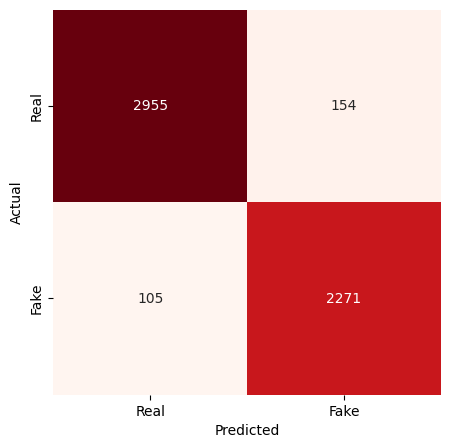

In [49]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(), yticklabels=label2id.keys(), fmt='d', cbar=False, cmap='Reds')
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

### Benchmarking

In [50]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
    "mobilebert": "google/mobilebert-uncased",
    "tinybert": "huawei-noah/TinyBERT_General_4L_312D"
}


def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    return preds.metrics



import time
model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/5485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.247100
1000,0.195400
1500,0.166700
2000,0.097400
2500,0.104800
3000,0.070900
3500,0.049500
4000,0.018300
4500,0.030000





Training Model:  distilbert


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/5485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.250900
1000,0.173200
1500,0.151100
2000,0.101900
2500,0.088500
3000,0.074700
3500,0.048500
4000,0.020400
4500,0.041300





Training Model:  mobilebert


pytorch_model.bin:   0%|          | 0.00/147M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/147M [00:00<?, ?B/s]

Map:   0%|          | 0/5485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,46156.336000
1000,0.248100
1500,0.602200
2000,0.177200
2500,0.112200
3000,0.110800
3500,0.071500
4000,0.044100
4500,0.052200





Training Model:  tinybert


pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

Map:   0%|          | 0/5485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Step,Training Loss
500,0.307100
1000,0.211700
1500,0.184900
2000,0.139300
2500,0.150200
3000,0.119400
3500,0.108700
4000,0.081200
4500,0.071500


In [51]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.1789267510175705,
   'test_accuracy': 0.9679124886052871,
   'test_f1': 0.9679411159092014,
   'test_runtime': 31.5001,
   'test_samples_per_second': 174.127,
   'test_steps_per_second': 21.778},
  'time taken': 939.0826489925385},
 'distilbert': {'distilbert': {'test_loss': 0.19491207599639893,
   'test_accuracy': 0.9631722880583409,
   'test_f1': 0.9632163150157959,
   'test_runtime': 15.9885,
   'test_samples_per_second': 343.06,
   'test_steps_per_second': 42.906},
  'time taken': 504.0857810974121},
 'mobilebert': {'mobilebert': {'test_loss': 0.19576704502105713,
   'test_accuracy': 0.9642661804922515,
   'test_f1': 0.9642697062613269,
   'test_runtime': 29.4605,
   'test_samples_per_second': 186.182,
   'test_steps_per_second': 23.285},
  'time taken': 878.9478516578674},
 'tinybert': {'tinybert': {'test_loss': 0.2054457664489746,
   'test_accuracy': 0.956608933454877,
   'test_f1': 0.9565586153236991,
   'test_runtime': 4.8216,
   'tes

### Build Prediction Function and Store Model

---



In [52]:
trainer.save_model("fake_news")

In [53]:
from transformers import pipeline

classifier = pipeline('text-classification', model= 'fake_news')

Device set to use cuda:0


In [54]:
classifier("some text data")

[{'label': 'Fake', 'score': 0.9726334810256958}]